# Classifying Blood Smears with a Convolutional Neural Network

This notebook provides you with a complete code example that loads the malaria dataset, trains a convolutional neural network with dense top to classify the images of cell with and without malaria, analyzes where the trained network fails, and shows the network activations and heatmaps.

## Loading the Malaria Dataset

This dataset was originally published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. _Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images._ PeerJ 6, e4568, 2018.

It is available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip.


In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

### Transforming the Images and Their Ground Thruth

Define a transformation to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1) ...

In [2]:
from torchvision.transforms import Compose, Resize, ToTensor 

image_transform = Compose([Resize((28, 28)), ToTensor()])

... define a transformation to make the target label equal to 0 for the uninfected cells and to 1 for the parasitized ones, converting it into a floating-point PyTorch tensor and adding a new dimension for batch processing ...

In [3]:
import torch

def label_transform(label):
    """Transform label."""
    return torch.tensor(1 - label).float().unsqueeze(-1)

... and define a dataset that also makes these transformations.

In [4]:
from torchvision.datasets import ImageFolder

base_dir = os.path.join(dataset_path, "cell_images")
dataset = ImageFolder(base_dir,
                      transform=image_transform,
                      target_transform=label_transform)

### Visualizing the Blood Smears

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_blood_smears(dataset, parasitized):
    """Plot blood smears."""
    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[np.random.randint(0, len(dataset))]
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
        ax.imshow(image)
        ax.set_title(f"Uninfected ({label})" if label == parasitized
                     else f"Parasitized ({label})")
    plt.tight_layout()
    plt.show()

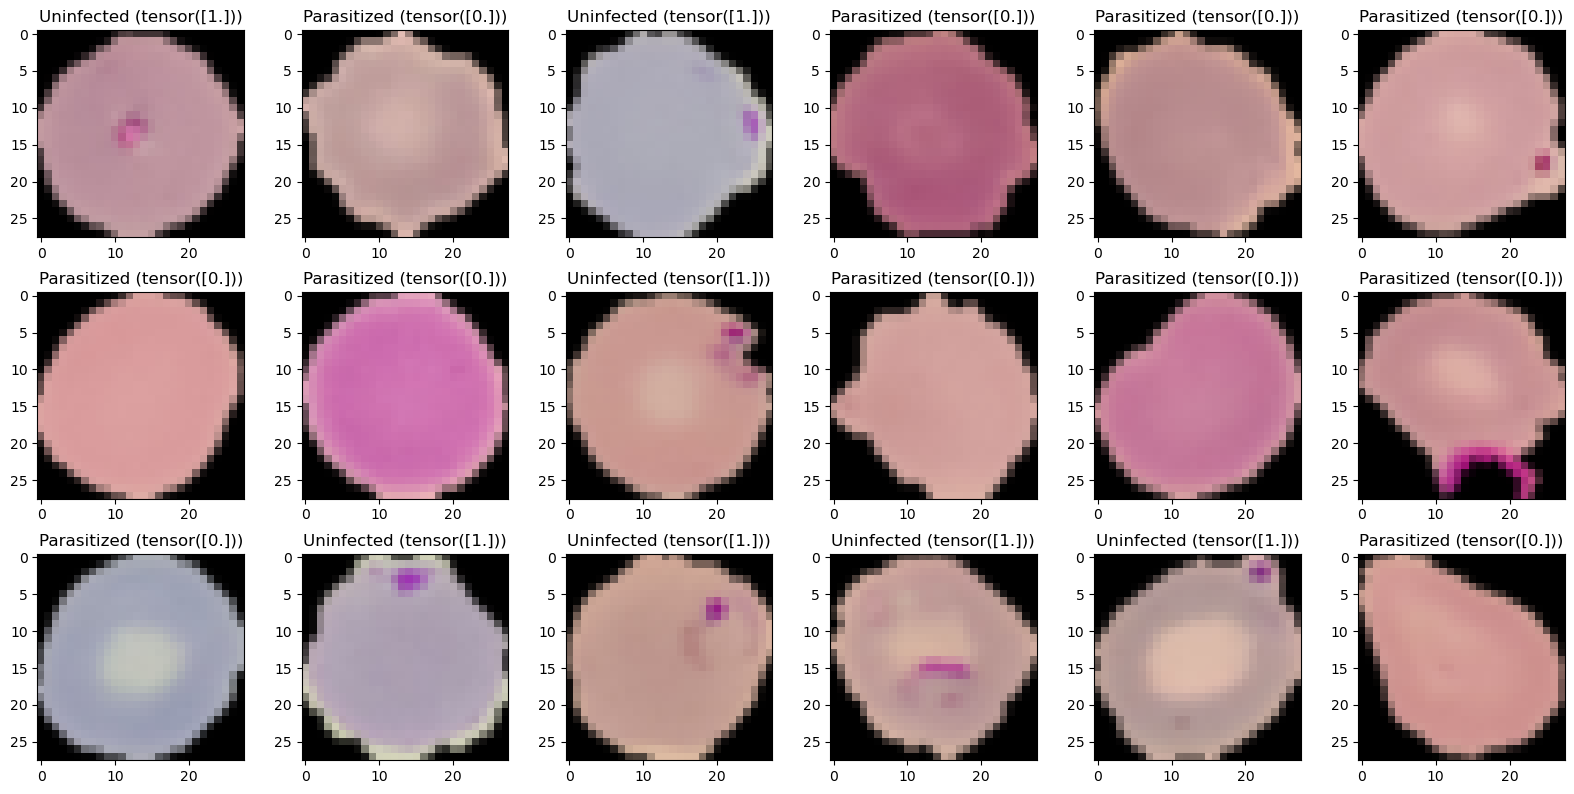

In [25]:
plot_blood_smears(dataset, parasitized=1)

### Splitting the Dataset and Defining the Data Loaders

Split the dataset, composed by ca. 27,000 cell images, into train (80%) and test (20%) sets.

In [8]:
from torch.utils.data import DataLoader, random_split

train, test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

## Classifying the Blood Smears with Dense Neural Networks

Implement a dense neural network ...

In [9]:
import deeplay as dl
from torch.nn import Sigmoid

dnn = dl.MultiLayerPerceptron(
    in_features=28 * 28 * 3, 
    hidden_features=[128, 128], 
    out_features=1,
    out_activation=Sigmoid, 
)

print(dnn)

... and compile it.

In [11]:
dnn_classifier_template = dl.BinaryClassifier(model=dnn,
                                              optimizer=dl.RMSprop(lr=0.001))
dnn_classifier = dnn_classifier_template.create()

print(dnn_classifier)

The default loss of `dl.BinaryClassifier` is a binary cross-entropy loss.

### Training the Dense Neural Network

In [12]:
dnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
dnn_trainer.fit(dnn_classifier, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-03-14 17:38:08.226908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | BCELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Testing the Dense Neural Network

In [13]:
dnn_trainer.test(dnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.6860823631286621
     test_loss_epoch        0.5941486358642578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.5941486358642578,
  'testBinaryAccuracy_epoch': 0.6860823631286621}]

### Plotting the ROC Curve

In [14]:
import torchmetrics as tm

def plot_roc(classifier, loader): 
    """Plot ROC curve."""
    roc = tm.ROC(task="binary")
    
    for image, label in loader: 
        roc.update(classifier(image), label.long())
    
    fig, ax = roc.plot(score=True) 
    ax.grid(False) 
    ax.axis("square") 
    ax.set_xlim(0, 1) 
    ax.set_ylim(0, 1) 
    ax.legend(loc="center right")

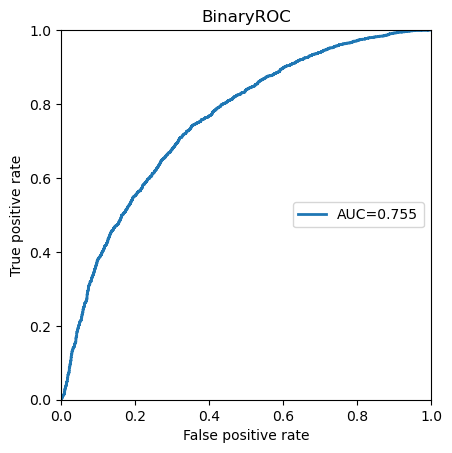

In [15]:
plot_roc(dnn_classifier, test_loader)

## Classifying the Blood Smears with Convolutional Neural Networks

Implement a convolutional neural network with a dense top ...

In [16]:
from torch.nn import AdaptiveAvgPool2d, MaxPool2d

conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=3, 
    hidden_channels=[32, 32, 64],
    out_channels=64,
)
conv_base.blocks[2].pool.configure(MaxPool2d, kernel_size=2)
connector = dl.Layer(AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=64, hidden_features=[],
    out_features=1,
    out_activation=Sigmoid,
)

cnn = dl.Sequential(conv_base, connector, dense_top)

print(cnn)

... and compile it.

In [17]:
cnn_classifier_template = dl.BinaryClassifier(model=cnn,
                                              optimizer=dl.RMSprop(lr=0.001))
cnn_classifier = cnn_classifier_template.create()

print(cnn_classifier)

### Training the Convolutional Neural Network

In [18]:
cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
cnn_trainer.fit(cnn_classifier, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | BCELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 65.6 K
5 | optimizer     | RMSprop          | 0     
---------------------------------------------------
65.6 K    Trainable params
0         Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pyto

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Testing the Convolutional Neural Network

In [19]:
cnn_trainer.test(cnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.9370350241661072
     test_loss_epoch        0.17604172229766846
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.17604172229766846,
  'testBinaryAccuracy_epoch': 0.9370350241661072}]

### Plotting the ROC Curve

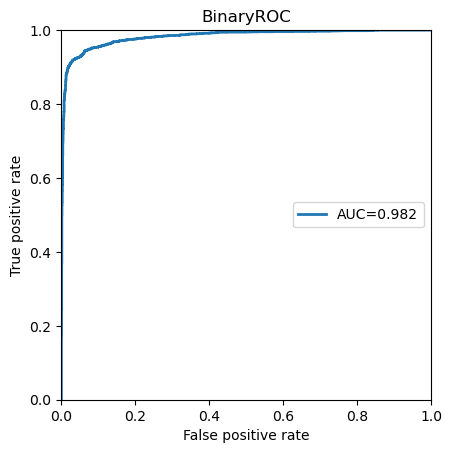

In [20]:
plot_roc(cnn_classifier, test_loader)

### Performing a Failure Analysis

In [31]:
def plot_failures(images, labels, pred, threshold=0.5, plot_num=5):
    """Plot incorrectly classified blood smears."""
    pred = np.array(pred).squeeze()
    gt = np.array(labels).squeeze()
    images = np.array(images)
    
    false_positives = (pred > threshold) & (labels == 0)
    false_positives_images = images[false_positives]
    
    false_negatives = (pred < threshold) & (labels == 1)
    false_negatives_images = images[false_negatives]
    
    plt.figure(figsize=(plot_num * 2, 5))
    for i in range(plot_num):
        # False positives.
        plt.subplot(2, plot_num, i + 1) 
        plt.imshow(false_positives_images[i].transpose(1, 2, 0)) 
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # False negatives.
        plt.subplot(2, plot_num, plot_num + i + 1) 
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0)) 
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)
    
    plt.tight_layout()
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

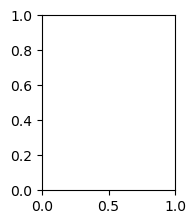

In [27]:
images, labels = zip(*test)
pred = cnn_classifier(torch.stack(images)).tolist()
plot_failures(images, labels, pred)

IndexError: index 0 is out of bounds for axis 0 with size 0

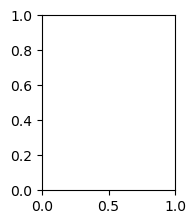

In [34]:
threshold=0.5
plot_num=5

"""Plot incorrectly classified blood smears."""
pred = np.array(pred).squeeze()
gt = np.array(labels).squeeze()
images = np.array(images)

false_positives = (pred > threshold) & (labels == 0)
false_positives_images = images[false_positives]

false_negatives = (pred < threshold) & (labels == 1)
false_negatives_images = images[false_negatives]

plt.figure(figsize=(plot_num * 2, 5))
for i in range(plot_num):
    # False positives.
    plt.subplot(2, plot_num, i + 1) 
    plt.imshow(false_positives_images[i].transpose(1, 2, 0)) 
    if i == 0:
        plt.title("False positives", fontsize=16, y=1.1)

    # False negatives.
    plt.subplot(2, plot_num, plot_num + i + 1) 
    plt.imshow(false_negatives_images[i].transpose(1, 2, 0)) 
    if i == 0:
        plt.title("False negatives", fontsize=16, y=1.1)

plt.tight_layout()
plt.show()

In [48]:
labels

(tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1

### Checking the Values of the Filters

In [28]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[31]
print(filter)

tensor([[[-0.0642,  0.1529,  0.0231],
         [ 0.0914, -0.0431, -0.0564],
         [-0.1647,  0.0547, -0.1290]],

        [[-0.1628, -0.1806, -0.0785],
         [-0.1377,  0.0616, -0.0518],
         [-0.0052, -0.1519,  0.1509]],

        [[-0.1858, -0.1737,  0.0698],
         [ 0.1584, -0.0514, -0.0027],
         [-0.0167, -0.1487, -0.0208]]], grad_fn=<SelectBackward0>)


## Failure analysis

We now write the `plot_failures` function, save it in `fnc_blood_smears.py` ...

```python
def plot_failures(images, labels, pred, threshold=.5, plot_num=5):
    from matplotlib import pyplot as plt 
    from numpy import array, squeeze
    
    pred = array(pred).squeeze()
    labels = array(labels).squeeze()
    images = array(images)

    false_positives = (pred > threshold) & (labels == 0)
    false_positives_images = images[false_positives]

    false_negatives = (pred < threshold) & (labels == 1)
    false_negatives_images = images[false_negatives]

    plt.figure(figsize=(plot_num * 2, 5))
    for i in range(plot_num):
        # false positives
        plt.subplot(2, plot_num, i + 1)
        plt.imshow(false_positives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # false negatives
        plt.subplot(2, plot_num, plot_num + i + 1)
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)

    plt.tight_layout()
    plt.show()
```

... and visualize some of the wrongly classified cells, looking for common patterns.

In [ ]:
from fnc_blood_smears import plot_failures
from torch import stack

images, gt = zip(*test)
pred = cnn_classifier(stack(images)).tolist()

plot_failures(images, gt, pred)

## Access Filters

We can access value of the filters used by the neural network. The follwoing code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[31]`). 

In [ ]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[31]

print(filter)

## Activations

We pick the image of an infected smear to then check the activations it produces on the last convolutional layer.

In [ ]:
from PIL import Image

im_ind = 0  # Select the index of an image

image_hr = Image.open(dataset.samples[im_ind][0])  # Retrieve the original image corresponding to the selected index.
image = image_transform(image_hr)  # Apply the same transformation used in preprocessing

label = label_transform(dataset.targets[im_ind])
print(label)  # Check that it corresponds to a Parasitized image (label = 1)

To visualize the network features, we can use `hooks`. These are functionalities that allows us to access the information that the model sees during forward and backward passes, such as activations and gradients.

To plot the activations, we use the `plot_activations()` function ...

```python
def plot_activations(activations, cols=8):
    from matplotlib import pyplot as plt

    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i)

    fig.tight_layout()
    plt.show()
```

... which is added to `fnc_blood_smears.py`.

In [ ]:
def hook_func(layer, input, output):
    from fnc_blood_smears import plot_activations
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_classifier.model[0].blocks:
    layer = block.layer
    handle_fwd_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_classifier.model(image.unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_fwd_hook.remove()

## Visalizing Heatmaps with Grad-CAM

We can also use hooks to keep tracks also of the gradients in the backward pass.

In [ ]:
hookdata = {}

def fwd_hook_func(layer, input, output):
    hookdata["activations"] = output.detach().clone()

def bwd_hook_func(layer, grad_input, grad_output):
    hookdata["gradients"] = grad_output[0].detach().clone()

layer = cnn_classifier.model[0].blocks[3].layer
handle_fwd_hook = layer.register_forward_hook(fwd_hook_func)
handle_bwd_hook = layer.register_full_backward_hook(bwd_hook_func)

try:
    pred = cnn_classifier.model(image.unsqueeze(0))
    pred.backward()
except Exception as e:
    print(f"An error occurred during model prediction: {e}")
finally:
    handle_fwd_hook.remove()
    handle_bwd_hook.remove()

We can now calculate the heatmap combining activations and gradients.

In [ ]:
from torch.nn.functional import relu

activations = hookdata["activations"][0]
gradients = hookdata["gradients"][0]

pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
heatmap = relu((pooled_gradients * activations).sum(0)).detach().numpy()

We can also combine activations and gradients to calculate Grad-CAM and inspect on which part of an image the CNN focuses on to predict its outputs, using the `def plot_heatmap()` function, which is added to `fns_blood_smears.py`.

```python
def plot_heatmap(image, heatmap):
    from matplotlib import pyplot as plt
    import skimage
    from numpy import array

    image = skimage.exposure.rescale_intensity(array(image), out_range=(0, 1))
    heatmap = skimage.transform.resize(heatmap, image.shape, order=2)
    heatmap = skimage.exposure.rescale_intensity(heatmap, out_range=(0.25, 1))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, interpolation="bilinear")
    plt.title("Original image", fontsize=16)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap.mean(axis=-1), interpolation="bilinear")
    plt.title("Heatmap with Grad-CAM", fontsize=16)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image * heatmap)
    plt.title("Overlay", fontsize=16)
    plt.axis("off")

    plt.tight_layout()
    plt.show()
```

In [ ]:
from fnc_blood_smears import plot_heatmap

plot_heatmap(image_hr, heatmap)

## Implementat Hooks with Context Managers

We define them as context manager classes, so that we can use them with the `with` statement. This ensures that the hooks are properly set up and removed when they are no longer needed, preventing potential side effects or memory leaks. This is particularly important in complex neural network models where maintaining computational efficiency and correctness is crucial.

Activations at a specific layer can be obtained from the forward pass using the `fwd_hook` class:

* The `__init__(self, layer)` method registers a forward hook to the provided model at a specific layer. The hook is set to the `hook_func()` method. This hook will be called every time the forward method of the model is executed.

* The `hook_func(self, layer, i, o)` method is called during the forward pass of the model: `layer` is the layer to which the hook is attached; `input` is the input to the model's layer; and `o` is the output from the model's layer. The output `o` is detached from the current computation graph and cloned to prevent any modifications to `o` from affecting the original tensor, and avoids potential issues with backpropagation. Note: `o[0]` is used because `o` is a tuple of activations, one for each image.

* The `__enter__(self, *args)` method returns this object when entering the context (using the `with` statement).

* The `__exit__(self, *args)` method removes the forward hook from the model when exiting the context. This is important for resource management and to ensure that the hook does not remain active beyond its intended scope.

```python
class fwd_hook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, i, o):
        print("Forward hook running ...") 
        self.activations = o.detach().clone()
        print(f"Activations size: {self.activations.size()}")

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()
```

Gradients at a specific layer can be obtained from the backward pass using the `bwd_hook` class:

* The `__init__(self, layer)` method registers a full backward hook to the provided model at a specific layer. The hook is set to the `hook_func`` method. This hook will be called every time the backward pass of the model is executed.

* The `hook_func(self, layer, gi, go)` function is called during the backward pass of the model: `layer` is the layer to which the hook is attached; `gi` represents the gradients with respect to the input; and `go` represents the gradients with respect to the output. The first output gradient `go[0]` is detached from the current computation graph and cloned. This prevents any modifications to `go[0]` from affecting the original tensor, and avoids potential issues with backpropagation. Note: `go[0]` is used because `go` is a tuple of gradients, one for each output (even though in this case we only have one input).

* The `__enter__(self, *args)` method returns this object when entering the context (using the `with` statement).

* The `__exit__(self, *args)` method removes the backward hook from the model when exiting the context. This is important to ensure that the hook is only active during the intended scope and to release any resources associated with the hook.

```python
class bwd_hook():
    def __init__(self, layer):
        self.hook = layer.register_full_backward_hook(self.hook_func)

    def hook_func(self, layer, gi, go):
        print("Backward hook running ...")
        self.gradients = go[0].detach().clone()
        print(f"Gradients size: {self.gradients.size()}")

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()
```

We add both classes to `fnc_blood_smears.py`.

In [ ]:
from fnc_blood_smears import fwd_hook, bwd_hook

layer = cnn_classifier.model[0].blocks[3].layer

with bwd_hook(layer) as bh, fwd_hook(layer) as fh:
    pred = cnn_classifier.model(image.unsqueeze(0))  # Forward pass through the model with the given image
    pred.backward()  # Executing the backward pass for backpropagation

In [ ]:
from fnc_blood_smears import plot_activations

plot_activations(fh.activations[0])

In [ ]:
from torch.nn.functional import relu
from fnc_blood_smears import plot_heatmap

pooled_gradients = bh.gradients[0].mean(dim=[1, 2], keepdim=True)
grad_cam = relu((pooled_gradients * fh.activations[0]).sum(0)).detach().numpy()

plot_heatmap(image_hr, grad_cam)